# Continuous Control with 20 agents

## Preamble

### The project

In this notebook, a DQN agent is used to solve a navigation problem as a first project for the  [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

Before using this notebook check that you have followed the .Readme file available in [GitHub Project repository](https://github.com/BDGITAI/RL_P1_Navigation/)

For the Notebook to work you will need the Banana environment executable which was placed in [GitHub Project repository](https://github.com/BDGITAI/RL_P1_Navigation/Banana_Windows_x86_64/). The environment needs to uncompressed in  `"../Banana_Windows_x86_64/Banana.exe"`

This DQN implementation uses the Pytorch library and was tested in a **Windows 64 bits** platform using **CPU**  computation. 


This notebook is divided in two parts
* **Part 1** : Training. We will train an Agent and see how the learning can be applied to execute a task
* **Part 2** : To see an already trained agent you can skip to Part 2 and load a trained agent.

### Base used for the project

here describe shangtong

---

## 1. Part 1 : Training 20 agents 

### 1.1 Imports and initialisation function
Import the deep_rl libraries from Shangtong and create a function creating the DDPG agent interacting with the Unity environment.

more pythonique 20 tasks with load of weights at each evaluation


In [1]:
from deep_rl import *

#
# Create a the Actor Critic Network that will be shared
# by all agents for evaluating actions. The unity environment requires all actions
# to be passed at once. Hence we can evaluate actions for the 20 agents successively
# and then step the environment. The unity env creates a bottleneck that limits the use
# of parallelism. With successive call there will be no competitive access to the network
# while training
# 

def shared_net(state_dim,action_dim):
     return (DeterministicActorCriticNet(
        state_dim, action_dim,
        actor_body=FCBody(state_dim, (400, 300), gate=F.tanh),
        critic_body=TwoLayerFCBodyWithAction(
            state_dim, action_dim, (400, 300), gate=F.tanh),
        actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-4),
        critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3)))

#
# Create a shared memory between 20 agents. 
# The stepping function of all agents will be called in sequence avoiding competing
# access when inserting or removing data from the memory
#   
def shared_mem():
    return Replay(memory_size=int(1e7), batch_size=64)  


#
#
#
def create_agents(num_agent,net,target_net,mem):
    config = Config()
    log_dir = get_default_log_dir(create_agents.__name__)
    config.task_fn = lambda **kwargs: ContinuousControl(config.eval_env,log_dir=log_dir)
    config.eval_env = Unity20()
    config.max_steps = int(1e6)
    config.eval_interval = int(1e4)
    config.eval_episodes = 20
    config.discount = 0.99
    config.random_process_fn = lambda: OrnsteinUhlenbeckProcess(
        size=(config.action_dim, ), std=LinearSchedule(0.2))
    config.min_memory_size = 64
    config.target_network_mix = 1e-3
    config.logger = get_logger()
    agents = []
    # create 20 agents 
    for i in range(num_agent):
        agents.append (DDPGAgent20(config,net,target_net,mem))
    return agents         

In [2]:
def train(agents,n_episodes=2000, max_t=1000,score_target=30):
    scores = []     # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        # reset environment at the start of each episode
        states = agents[0].config.eval_env.reset()
        for agent,state in zip(agents,states):
            agent.state = state
        # no reward at start
        episode_rewards = np.zeros(len(agents))
        ep_scores = np.zeros(len(agents))
        for t in range(max_t):
            # decide wich action to take according to eps greedy policy
            actions = []
            for agent in agents:
                action = agent.half_step1()
                actions.append(action)
            # execute the action in the environment (interface with unity)
            next_states, rewards, dones, infos = agent.config.eval_env.step(actions)
            # store this experience in the memory and learn if enough experiences have been gathered
            for agent,action,next_state,reward,done,info in zip(agents,actions,next_states, rewards, dones, infos):
                agent.half_step2(action,next_state,reward,done,info)
            # update current state as next state
            for agent,state in zip(agents,next_states):
                agent.state = state
            # cumul reward
            ep_scores += rewards
            if np.any(dones):
                break 
        score = np.mean(ep_scores)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}\tMax Score: {:.2f}'.format(i_episode, np.mean(scores_window),np.max(scores_window)), end="")
        # save network weigth every 100 episodes
        if i_episode % 20 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            path = 'checkpoint20_'+str(i_episode)+'.pth'
            agent.save(path)
            # save score
            f = open('output20.txt', 'w')
            f.write('score: '+ str(scores)+'\n')
            f.close()
        # target is 30 to win. 
        if np.mean(scores_window)>=score_target:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            path = 'checkpoint20_'+str(i_episode)+'.pth'
            agent.save(path)
            # save score
            f = open('output20.txt', 'w')
            f.write('score: '+ str(scores)+'\n')
            f.close()
            break
    return scores



In [3]:
mkdir('data/video')
mkdir('dataset')
mkdir('log')
set_one_thread()
select_device(-1)
                       
network = shared_net(33,4)
target_network = shared_net(33,4)
replay = shared_mem()
agents = create_agents(20,network,target_network,replay)
scores = train(agents)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 20	Average Score: 2.90	Max Score: 4.63
Episode 40	Average Score: 4.16	Max Score: 7.26
Episode 60	Average Score: 5.31	Max Score: 8.36
Episode 80	Average Score: 5.79	Max Score: 9.59
Episode 100	Average Score: 5.97	Max Score: 9.59
Episode 120	Average Score: 6.65	Max Score: 9.59
Episode 140	Average Score: 6.71	Max Score: 9.59
Episode 160	Average Score: 6.27	Max Score: 9.59
Episode 163	Average Score: 6.25	Max Score: 9.59

KeyboardInterrupt: 

In [3]:
network = shared_net(33,4)
target_network = shared_net(33,4)
replay = shared_mem()
agents = create_agents(20,network,target_network,replay)
for agent in agents:
    agent.load('checkpoint20_160_s.pth')
scores_2_phase = train(agents, n_episodes=200, max_t=500, score_target =16.0)
agent.config.eval_env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 20	Average Score: 0.89	Max Score: 1.66
Episode 40	Average Score: 1.57	Max Score: 2.89
Episode 60	Average Score: 2.22	Max Score: 4.94
Episode 80	Average Score: 2.74	Max Score: 5.50
Episode 100	Average Score: 3.31	Max Score: 6.39
Episode 120	Average Score: 4.36	Max Score: 7.11
Episode 140	Average Score: 5.31	Max Score: 8.09
Episode 160	Average Score: 6.30	Max Score: 10.00
Episode 180	Average Score: 7.89	Max Score: 14.08
Episode 200	Average Score: 9.51	Max Score: 15.66


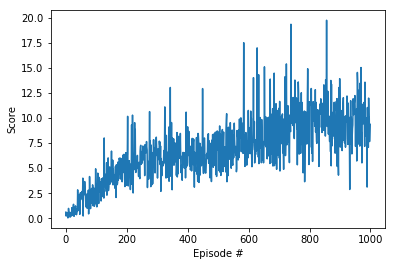

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [4]:
agent.config.eval_env.close()

AttributeError: module 'deep_rl.utils.config' has no attribute 'eval_env'

In [ ]:

network = shared_net(33,4)
target_network = shared_net(33,4)
replay = shared_mem()
agents = create_agents(20,network,target_network,replay)
for agent in agents:
    agent.load('checkpoint20_200.pth')
brain_name = agent.config.eval_env.env.brain_names[0]
env_info = agent.config.eval_env.env.reset(train_mode=False)[brain_name] 
states = env_info.vector_observations
scores = np.zeros(20)                        # initialize the score (for each agent)
while True:
    actions = []
    for agent,state in zip(agents,states):
        actions.append(agent.eval_step(state))
    # execute the action in the environment (interface with unity)
    env_info = agent.config.eval_env.env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
agent.config.eval_env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
import matplotlib.pyplot as plt

def eval(agent,n_episodes=100):
    num_agents =1
    brain_name = agent.config.eval_env.env.brain_names[0]
    env_info = agent.config.eval_env.env.reset(train_mode=False)[brain_name] 
    state = env_info.vector_observations[0]
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    time_steps =[]
    time_steps_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        score = 0
        time_step = 0
        while True:
            action = agent.eval_step(state)
            # execute the action in the environment (interface with unity)
            next_state, reward, done, info = agent.config.eval_env.step(action)
            # update current state as next state
            state = next_state
            # cumul rewrd
            score += reward
            time_step +=1
            if done:                                  # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        time_steps_window.append(time_step)       # save most recent score
        time_steps.append(time_step)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}\tMax Score: {:.2f}\tAverage time_steps: {:.2f}\tMax time_steps: {:.2f}'.format(i_episode, np.mean(scores_window),np.max(scores_window), np.mean(time_steps_window),np.max(time_steps_window)), end="")
    return scores,time_steps

agent = ddpg_low_dim_state_unity()
agent.load('checkpoint_1600.pth')  
scores,time_steps = eval(agent)

print('\rResults \tAverage Score: {:.2f}\tMax Score: {:.2f}\Min Score: {:.2f}'.format(np.mean(scores),np.max(scores),np.min(scores)), end="")
print('\rResults \tAverage time_steps: {:.2f}\tMax time_steps: {:.2f}\tMin time_steps: {:.2f}'.format(np.mean(time_steps),np.max(time_steps),np.min(time_steps)), end="")

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

agent.config.eval_env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 225	Average Score: 36.69	Max Score: 39.72	Average time_steps: 1001.00	Max time_steps: 1001.00